# Predicting online shoppers’ purchasing intention
## Classification using SHAP for feature interpretation and selection
Models tested
* Logistic Regression
* Decision Tree
* Random Forest
* Extra Trees
* AdaBoost
* Gradient Boosting
* XGBoost

**Goal: Understand model predictions and improve model performance using SHAPley values to subset features by importance**

---

Data source:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

SHAP:
https://shap.readthedocs.io/en/latest/index.html


In [1]:
# download from github
%%capture
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/X_test.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/X_train.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/y_test.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/y_train.npy;

## to view curr directory
# !ls
!pip install shap


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pprint
import warnings
from collections import Counter

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, TransformerMixin
# from imblearn.over_sampling import SMOTE  # try for imbalanced classes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
# datasets to test
# from sklearn.datasets import load_iris
# from sklearn.datasets import make_moons, make_circles, make_classification

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

# metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, classification_report

import shap
shap.initjs()

In [3]:
## Load cleaned data arrays
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13972, 28) (4069, 28) (13972,) (4069,)


In [9]:
feature_names2 = ['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'VisitorType_New_Visitor',
 'VisitorType_Other',
 'VisitorType_Returning_Visitor',
 'Weekend_True',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType']

print(len(feature_names2))

28


In [10]:
X_train = pd.DataFrame(X_train, columns=feature_names2)
X_test = pd.DataFrame(X_test, columns=feature_names2)

# Tuning Hyperparameters

In [11]:
model = LogisticRegression()
# what possible params to tune
pprint.pprint(model.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [12]:
# specify parameters and distributions to sample from
param_dist = {
    'penalty': ['none'],
    # 'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

# Random search of parameters, using cross validation, use all cores
model_rand = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

In [13]:
# Fit the random search model
model_rand.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'penalty': ['none'],
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga']},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
        

In [14]:
# print results of rand grid search
best_params = model_rand.best_params_
pprint.pprint(best_params)

{'penalty': 'none', 'solver': 'newton-cg'}


In [15]:
## Model new (optimized from results of grid search)
model_best = LogisticRegression(**best_params)
model_best.fit(X_train,y_train)  # fit the model to the training data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
## Get CV score
score = cross_val_score(model_best, X_train, y_train)
print(np.round(score.mean(), 4))

0.8513


In [17]:
## Calc Prec, Recall, F1 scores on test set
from google.colab import files
y_pred = model_best.predict(X_test)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report1 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report1)
report1_df = pd.DataFrame(report1).transpose()

model_name = "LogisticRegression"
report1_df.to_csv(f"{model_name}_report1.csv", index=False)
files.download(f"{model_name}_report1.csv")

{'0: No Revenue': {'precision': 0.9376558603491272, 'recall': 0.8754365541327125, 'f1-score': 0.905478627332932, 'support': 3436}, '1: Revenue': {'precision': 0.502903600464576, 'recall': 0.684044233807267, 'f1-score': 0.5796519410977242, 'support': 633}, 'accuracy': 0.8456623248955517, 'macro avg': {'precision': 0.7202797304068516, 'recall': 0.7797403939699897, 'f1-score': 0.7425652842153281, 'support': 4069}, 'weighted avg': {'precision': 0.8700229823675787, 'recall': 0.8456623248955517, 'f1-score': 0.854790917235393, 'support': 4069}}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
round(roc_auc_score(y_test, model_best.predict_proba(X_test)[:,1]),4)

0.8716

## SHAP visuals 

To show feature contributions to the model output (magnitude, postiive or negative class, num of samples, ...)


Types of plots
* Force Plot
* Bar Plot
* Beeswarm Plot / Scatter Plot
* Waterfall Plot (for indiv preds)

In [19]:
## Take smaller samples for visualization
X_train_sample = shap.utils.sample(X_train, nsamples=50, random_state=0)
X_test_sample = shap.utils.sample(X_test, nsamples=50, random_state=0)

## Kernel Explainer

In [20]:
# explain predictions of model on test set
explainer = shap.KernelExplainer(model_best.predict_proba, X_train_sample)

# compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

In [ ]:
# Force Plot
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample)

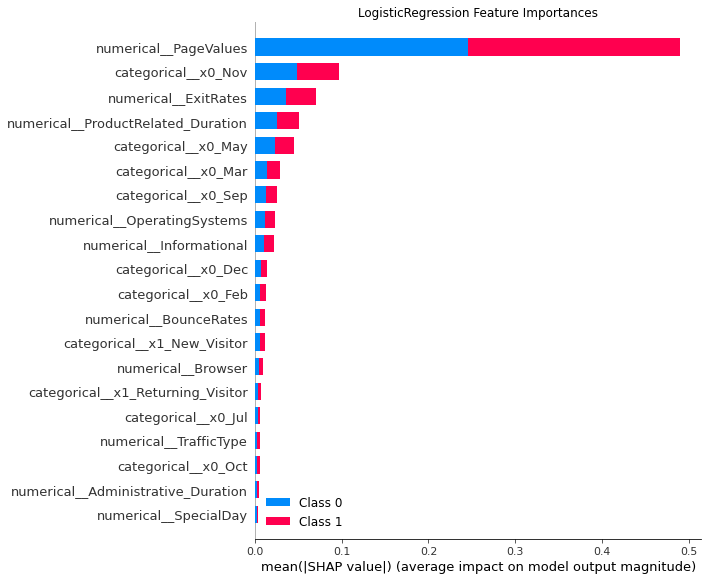

In [ ]:
plt.title(f"{model_name} Feature Importances")
shap.summary_plot(shap_values, (X_test_sample))

Bar Plot:

creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

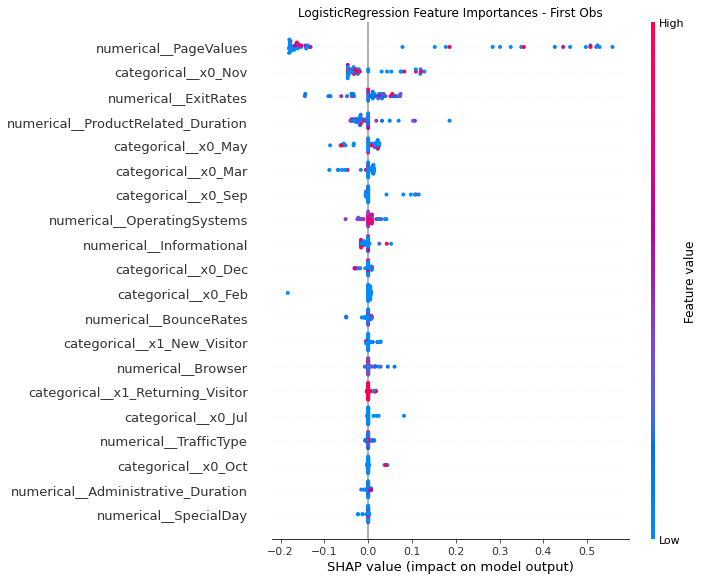

In [ ]:
# # index [1] represents class label 1
plt.title(f"{model_name} Feature Importances - First Obs")
shap.summary_plot(shap_values[1], X_train_sample)

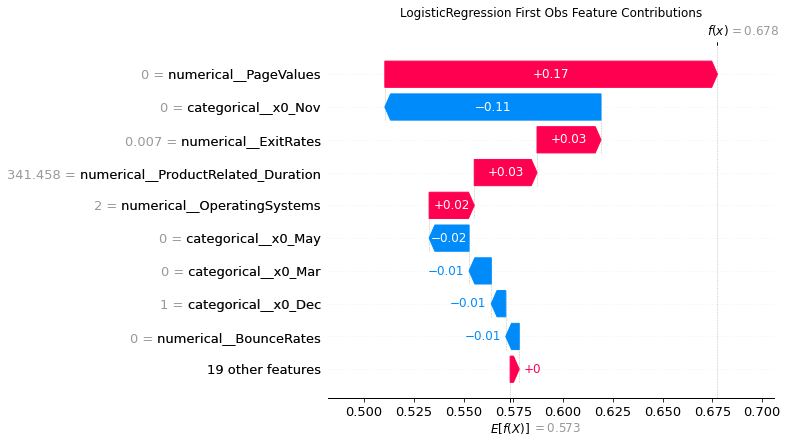

In [ ]:
# # Waterfall plot
# # ## Designed for INDIVIDUAL preds
# shap.plots.waterfall(shap_values[0])
plt.title(f"{model_name} First Obs Feature Contributions")
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], X_train_sample.iloc[0])

shap_values is a list of 2 arrays, representing class labels 0 and 1.

Both arrays have 50 observations and 29 features.

## Get the most and least important features

In [21]:
## Get mean of all training sample shap values
## Then get TOP 20 Features

## shap_value is a list of 2 np arrays
# print(shap_values[0].shape). ## this is training sample

train_shap_avg = np.average(shap_values[0], axis=0)
# print(train_shap_avg.shape)
train_shap_avg_2 = []
for i, val in enumerate(list(train_shap_avg)):
  train_shap_avg_2.append((i, feature_names2[i], val))

sorted_shap = sorted(train_shap_avg_2, key=lambda x: x[2])
top_20 = sorted_shap[:20]
top_20_indices = [t[0] for t in top_20]
to_keep = top_20_indices

In [22]:
to_keep = top_20_indices

## New Model from Subset of Features

In [23]:
## Subset of training data using top N most important features from SHAP
X_train_ss = X_train.iloc[:,to_keep]
X_train_ss.shape

(13972, 20)

In [24]:
# specify parameters and distributions to sample from
param_dist = {
    'penalty': ['none'],
    # 'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

# Random search of parameters, using cross validation, use all cores
model_rand = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

model_rand.fit(X_train_ss, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'penalty': ['none'],
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga']},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
        

In [25]:
# print results of rand grid search
best_params2 = model_rand.best_params_
pprint.pprint(best_params2)

{'penalty': 'none', 'solver': 'lbfgs'}


In [26]:
# With new hps (best_params2)
model_best = LogisticRegression(**best_params2)
model_best.fit(X_train_ss, y_train)  # fit the model to the training data

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
## With OLD hps
model_old = LogisticRegression(**best_params)
model_old.fit(X_train_ss, y_train)  # fit the model to the training data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
## Get CV score for SHAP data
score = cross_val_score(model_best, X_train_ss, y_train)
print(np.round(score.mean(), 4))

# With old hps
score2 = cross_val_score(model_old, X_train_ss, y_train)
print(np.round(score2.mean(), 4))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

0.685
0.6845


New hps did better than old. Use model_best for final repoprt

In [29]:
## Calc Prec, Recall, F1 scores on test set
X_test_ss = X_test.iloc[:,to_keep]
y_pred = model_best.predict(X_test_ss)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report2 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report2)
report2_df = pd.DataFrame(report2).transpose()
# model_name = str(model).strip('()')
report2_df.to_csv(f"{model_name}_report2.csv", index=False)
files.download(f"{model_name}_report2.csv")

{'0: No Revenue': {'precision': 0.8953626634958383, 'recall': 0.6574505238649593, 'f1-score': 0.7581809028360463, 'support': 3436}, '1: Revenue': {'precision': 0.23868046571798188, 'recall': 0.5829383886255924, 'f1-score': 0.33868747131711796, 'support': 633}, 'accuracy': 0.6458589333988695, 'macro avg': {'precision': 0.5670215646069101, 'recall': 0.6201944562452759, 'f1-score': 0.5484341870765821, 'support': 4069}, 'weighted avg': {'precision': 0.7932049266579462, 'recall': 0.6458589333988695, 'f1-score': 0.6929217870455618, 'support': 4069}}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Report1 is with full dataset. Report2 is with subset of features chosen by SHAP.

In [ ]:
print(round(roc_auc_score(y_test, model_best.predict_proba(X_test_ss)[:,1]),4))
print(round(roc_auc_score(y_test, model_old.predict_proba(X_test_ss)[:,1]),4))

0.8993
0.9197
